# Arbitrary Butcher Tableaus and Adaptive Integration

In this notebook, we will go through the process of expanding our code in order to allow for different Butcher tableaus and how to implement a step-size adaptation algorithm.

We have moved the `compensated_sum` function into our module under `neuralode.util.compensated_sum` and added a function `neuralode.util.partial_compensated_sum` that can be called with the partial sums and truncated bits for iteratively updated the tracked values. This simplifies our integration code by removing the duplication.

The plotting code has been moved into `neuralode.plot.trajectory.plot_trajectory` and `neuralode.plot.trajectory.plot_trajectory_with_reference`. The `neuralode.plot.trajectory.plot_trajectory` plots a trajectory without a reference solution which we will encounter with systems that don't have a closed form solution. We will be using the concept of a reference where a higher precision solver can be used to compute the trajectory. 

In [1]:
import typing
import warnings

import torch
import einops
import neuralode

warnings.simplefilter('once', RuntimeWarning)

In [2]:
# For convenience, we define the default tensor device and dtype here
torch.set_default_device('cpu')
# In neural networks, we prefer 32-bit/16-bit floats, but for precise integration, 64-bit is preferred. We will revisit this later when we need to mix integration with neural network training
torch.set_default_dtype(torch.float64)

We'll be starting with the same function from the previous notebook, but we have tidied up the code by using `neuralode.util.partial_compensated_sum` to track the truncated bits instead of duplicating the code through our integration function.

In [3]:
class IntegrateRK4(torch.autograd.Function):
    @staticmethod
    def forward(ctx, fn, x0, t0, t1, dt):
        """
        A general integration routine for solving an Initial Value Problem
        using the Classical Fourth-Order Method.
        
        Instead of naively summing the changes, we use compensated summation.
        
        :param fn: the function to be integrated
        :param initial_state: the initial state to integrate from
        :param initial_time: the initial time to integrate from
        :param final_time: the final time to integrate to
        :param timestep: the time increments to integrate with 
        :return: a tuple of ((the final state, the final time), the intermediates states [list]) 
        """
        # The names for the variables have been shortened for concision, and
        # to avoid overlap with variables in the outer scope
        # I have also left the annotations as they are invaluable for tracking the method. 
        c_time = t0.clone()
        c_state = x0.clone()
        
        # We'd like to track the whole trajectory, not just the final state, so we use a list to store the intermediate states and times
        i_states = [(c_state.clone(), c_time.clone())]
        
        # We write out the butcher tableau for easier computation
        butcher_tableau = torch.tensor([
            # c0, a00, a01, a02, a03
            [0.0, 0.0, 0.0, 0.0, 0.0],
            # c1, a10, a11, a12, a13
            [0.5, 0.5, 0.0, 0.0, 0.0],
            # c2, a20, a21, a22, a23
            [0.5, 0.0, 0.5, 0.0, 0.0],
            # c3, a30, a31, a32, a33
            [1.0, 0.0, 0.0, 1.0, 0.0],
            #     b0,  b1,  b2,  b3
            [0.0, 1/6, 2/6, 2/6, 1/6]
        ], dtype=x0.dtype, device=x0.device)
        # We see here that this method of writing out the tableau, while complete,
        # is inefficient given that so many entries are zero.
        # Ideally, we would have a more compressed format, but for our purposes,
        # this works.
        
        # At each step we repeat the same procedure with differing states and times 
        # (and step sizes for the last step), thus it makes sense to 
        # wrap everything in a local function which can be called repeatedly.
        def compute_step(state, time, step):
            # We need to store the intermediate stages
            k_stages = torch.stack([torch.zeros_like(time)]*(butcher_tableau.shape[1] - 1))
            # we subtract one since the last row is the final state
            for stage_index in range(butcher_tableau.shape[0] - 1):
                c_coeff, *a_coeff = butcher_tableau[stage_index]
                k_stages[stage_index] = fn(
                    # We use `compensated_sum` instead of sum in order to avoid truncation at each stage calculation
                    state + step * neuralode.util.compensated_sum(k*a for k,a in zip(k_stages, a_coeff)), 
                    time + c_coeff * step
                )
            # We return the change in the state and the change in the time as we track partial sums
            # Again, we use `compensated_sum` to avoid truncation in the final stage calculations
            return step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-1, 1:])), step
        
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(c_state)
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(c_time)
        
        # We integrate as long as the current_time+dt is less than t1
        # Essentially, we want to stop the integration if taking another step
        # would lead to exceeding the final time
        while torch.any((c_time + dt) < t1):
            # To compute the change in state, we add the truncated bits back
            delta_state, delta_time = compute_step(c_state, c_time, dt)
            c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
            c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
            # We would like to store the intermediate states with the compensated partial sums
            i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
            
        delta_state, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, t1 - (c_time + truncated_bits_time))
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
        
        i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
        
        ctx.save_for_backward((c_state, c_time, i_states))
        ctx.integration_function = fn
        
        return (c_state, c_time), i_states

Similarly, we'll test our implementation on the same exponential system before moving on.

In [4]:
x0 = torch.tensor([1.0])
t0 = torch.tensor(0.0)
t1 = torch.tensor(1.0)
N  = 5
dt = (t1 - t0) / N

Error in RK4: 5.79695385960477e-06


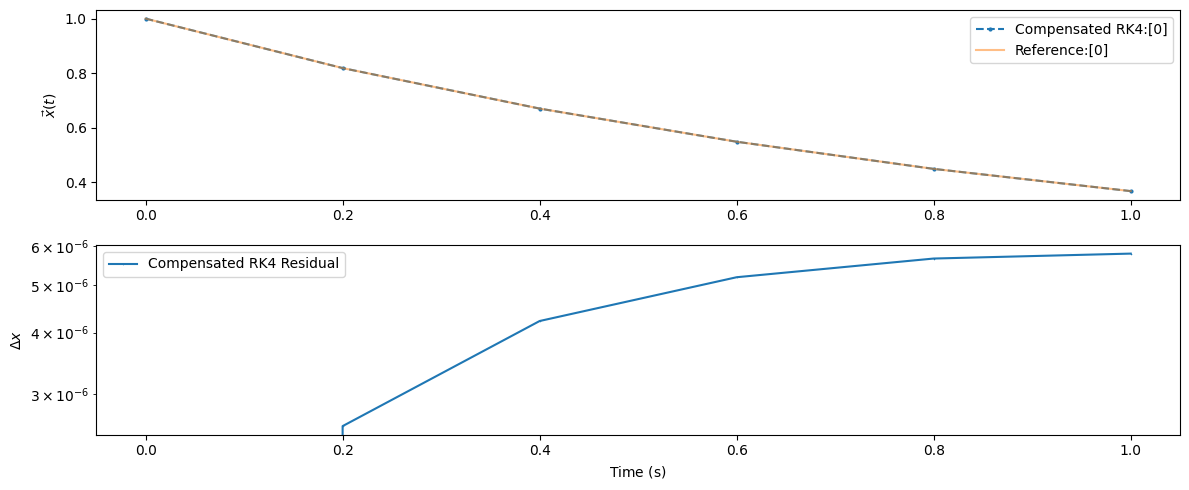

In [5]:
(f_state, f_time), sub_states = IntegrateRK4.apply(neuralode.dynamics.exponential_fn, x0, t0, t1, dt)
reference_trajectory = [neuralode.dynamics.exponential_fn_solution(x0, t) for _,t in sub_states]

fig, axes = neuralode.plot.trajectory.plot_trajectory_with_reference(sub_states, reference_trajectory, method_label="Compensated RK4")

print(f"Error in RK4: {(f_state - neuralode.dynamics.exponential_fn_solution(x0, t1)).abs().item()}")

Now that we have verified that the previous code is still correct and working with our code in the module, we can start parametrisation of the integrator as a function of the Butcher Tableau.

The following code takes advantage of the dynamic type system in Python, more specifically, we can generate a class and define its methods dynamically as well as store the tableau itself as an attribute of the class. In this fashion, we can have a function that takes a tableau as a PyTorch tensor and returns a PyTorch function that can integrate a system.

This will enable us to test out different integration algorithms without having to write a new class for each one. Eventually we will move this function into the module and add different integration algorithms at import time.

In [6]:
def get_integrator(integrator_tableau: torch.Tensor, integrator_name: str = None) -> torch.autograd.Function:
    __integrator_type = type(integrator_name, (torch.autograd.Function,), {
        "integrator_tableau": integrator_tableau
    })
    def __internal_forward(ctx, fn, x0, t0, t1, dt):
        """
        A general integration routine for solving an Initial Value Problem
        using any arbitrary Butcher Tableau
        
        Instead of naively summing the changes, we use compensated summation.
        
        :param fn: the function to be integrated
        :param initial_state: the initial state to integrate from
        :param initial_time: the initial time to integrate from
        :param final_time: the final time to integrate to
        :param timestep: the time increments to integrate with 
        :return: a tuple of ((the final state, the final time), the intermediates states [list]) 
        """
        c_time = t0.clone()
        c_state = x0.clone()
        
        i_states = [(c_state.clone(), c_time.clone())]
        
        butcher_tableau = __integrator_type.integrator_tableau.clone().to(x0.device, x0.dtype)

        def compute_step(state, time, step):
            # We need to store the intermediate stages
            k_stages = torch.stack([torch.zeros_like(time)]*(butcher_tableau.shape[1] - 1))
            # we subtract one since the last row is the final state
            for stage_index in range(butcher_tableau.shape[0] - 1):
                c_coeff, *a_coeff = butcher_tableau[stage_index]
                k_stages[stage_index] = fn(
                    # We use `compensated_sum` instead of sum in order to avoid truncation at each stage calculation
                    state + step * neuralode.util.compensated_sum(k*a for k,a in zip(k_stages, a_coeff)), 
                    time + c_coeff * step
                )
            return step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-1, 1:])), step
        
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(c_state)
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(c_time)
        
        while torch.any((c_time + dt) < t1):
            delta_state, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, dt)
            c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
            c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
            
            i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
            
        delta_state, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, (t1 - c_time) - truncated_bits_time)
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
        
        i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
        
        ctx.save_for_backward((c_state, c_time, i_states))
        ctx.integration_function = fn
        
        return (c_state, c_time), i_states        
    __integrator_type.forward = staticmethod(__internal_forward)
    return __integrator_type

In [7]:
explicit_rk4_integrator = get_integrator(torch.tensor([
            # c0, a00, a01, a02, a03
            [0.0, 0.0, 0.0, 0.0, 0.0],
            # c1, a10, a11, a12, a13
            [0.5, 0.5, 0.0, 0.0, 0.0],
            # c2, a20, a21, a22, a23
            [0.5, 0.0, 0.5, 0.0, 0.0],
            # c3, a30, a31, a32, a33
            [1.0, 0.0, 0.0, 1.0, 0.0],
            #     b0,  b1,  b2,  b3
            [0.0, 1/6, 2/6, 2/6, 1/6]
        ], dtype=torch.float64), integrator_name = "ExplicitRungeKutta4")
explicit_midpoint_integrator = get_integrator(torch.tensor([
            # c0, a00, a01
            [0.0, 0.0, 0.0],
            # c1, a10, a11
            [0.5, 0.5, 0.0],
            #     b0,  b1
            [0.0, 0.0, 1.0]
        ], dtype=torch.float64), integrator_name = "ExplicitMidpoint")

Error in <class '__main__.ExplicitMidpoint'>: 1.5334058023341868e-08
Error in <class '__main__.ExplicitRungeKutta4'>: 2.220446049250313e-16


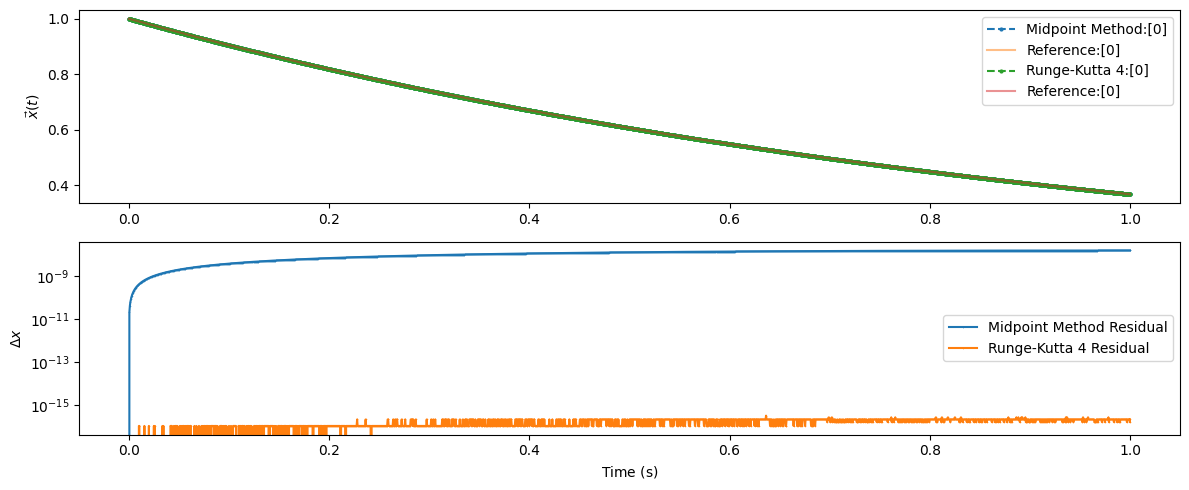

In [8]:
dt = (t1 - t0)/2000

(f_state, f_time), sub_states = explicit_midpoint_integrator.apply(neuralode.dynamics.exponential_fn, x0, t0, t1, dt)
reference_trajectory = [neuralode.dynamics.exponential_fn_solution(x0, t) for _,t in sub_states]

print(f"Error in {explicit_midpoint_integrator}: {(f_state - neuralode.dynamics.exponential_fn_solution(x0, t1)).abs().item()}")

fig, axes = neuralode.plot.trajectory.plot_trajectory_with_reference(sub_states, reference_trajectory, method_label="Midpoint Method")

(f_state, f_time), sub_states = explicit_rk4_integrator.apply(neuralode.dynamics.exponential_fn, x0, t0, t1, dt)
fig, axes = neuralode.plot.trajectory.plot_trajectory_with_reference(sub_states, reference_trajectory, axes=axes, method_label="Runge-Kutta 4")

print(f"Error in {explicit_rk4_integrator}: {(f_state - neuralode.dynamics.exponential_fn_solution(x0, t1)).abs().item()}")

We can see that this simplifies testing of different integration methods, and we could even use it to optimise the tableau itself since PyTorch allows for differentiating tensor variables (but I digress). For now, we will focus on how to implement an adaptive integration scheme. To identify whether a tableau if adaptive, we can use the first column of the rows with the $b_i$ coefficients and put a `torch.inf` value in their place. As this value is ignored during integration, it will be a way of signalling that the rows with `torch.inf` are used as the $b_i$ coefficients.  

Let's implement this!

In [9]:
def get_integrator(integrator_tableau: torch.Tensor, integrator_order: int, use_local_extrapolation: bool = True, integrator_name: str = None) -> torch.autograd.Function:
    # We look at the first column of the last two rows, and if both are `inf`, we know the method is adaptive
    is_adaptive = torch.isinf(integrator_tableau[-1,0]) and torch.isinf(integrator_tableau[-2,0])
    # The number of stages is the number of rows minus the last row
    # (or last two rows if the method is adaptive)
    number_of_stages = integrator_tableau.shape[0] - 1
    if is_adaptive:
        number_of_stages -= 1
    # The `type` function in this form works to dynamically create a class
    # the first parameter is the class name, the second are parent classes,
    # and the last are the class attributes. We store the integrator attributes 
    # here, and reference them in the integration code.
    # In this way, we can query these parameters at a future point.
    __integrator_type = type(integrator_name, (torch.autograd.Function,), {
        "integrator_tableau": integrator_tableau,
        "integrator_order": integrator_order,
        "is_adaptive": is_adaptive,
        "number_of_stages": number_of_stages
    })
    def __internal_forward(ctx, fn: typing.Callable[[torch.Tensor, torch.Tensor, typing.Any], torch.Tensor], 
                           x0: torch.Tensor, t0: torch.Tensor, t1: torch.Tensor, dt: torch.Tensor,
                           atol: torch.Tensor, rtol: torch.Tensor, *additional_dynamic_args):
        """
        A general integration routine for solving an Initial Value Problem
        using any arbitrary Butcher Tableau
        
        Instead of naively summing the changes, we use compensated summation.
        
        :param fn: the function to be integrated
        :param initial_state: the initial state to integrate from
        :param initial_time: the initial time to integrate from
        :param final_time: the final time to integrate to
        :param timestep: the time increments to integrate with
        :param atol: The absolute tolerance for the error in an adaptive integration
        :param rtol: The relative tolerance for the error in an adaptive integration
        :param additional_dynamic_args: additional arguments to pass to the function
        :return: a tuple of ((the final state, the final time), the intermediate states [list[torch.Tensor]], the error values [list[torch.Tensor]]) 
        """        
        if __integrator_type.is_adaptive:
            # We need to check that both `atol` and `rtol` are valid values and are compatible with the state
            atol = torch.abs(atol) # Need to ensure that the tolerance is a strictly positive number
            if atol.dim() != 0:
                # We can set per-component tolerances, but that means that the shapes of x0 and atol/rtol are compatible.
                # To test this, we try to add the tolerance to the initial state and check for errors
                try:
                    _ = x0.clone() + atol.clone()
                except RuntimeError:
                    raise ValueError(f"Expected shape of x0 and atol to be compatible, got {x0.shape} and {atol.shape} respectively")
            # 
            if torch.any((atol < torch.finfo(x0.dtype).eps) & (atol != 0.0)):
                # If any component of `atol` is too small, we adjust the values to be compatible with the datatype
                # To preserve differentiability, we divide out the detached value of `atol` and multiply by the epsilon 
                warnings.warn(f"Absolute tolerance is too small for tensor dtype: {x0.dtype}. Set atol={torch.finfo(x0.dtype).eps}.", RuntimeWarning)
                atol = torch.where((atol < torch.finfo(x0.dtype).eps) & (atol != 0.0), (atol/atol.detach())*torch.finfo(x0.dtype).eps, atol) 
            elif torch.any(atol < torch.finfo(x0.dtype).eps**0.5):
                # When the tolerances are tiny (roughly eps^0.5), truncation error can start to dominate
                # while we are compensating for this using Kahan summation, the user should be informed that this may cause issues.
                warnings.warn(f"Absolute tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error", RuntimeWarning)
            rtol = torch.abs(rtol) # Need to ensure that the tolerance is a strictly positive number
            if rtol.dim() != 0:
                # We can set per-component tolerances, but that means that the shapes of x0 and atol/rtol are compatible.
                # To test this, we try to add the tolerance to the 
                try:
                    _ = x0.clone() + rtol.clone()
                except RuntimeError:
                    raise ValueError(f"Expected shape of x0 and rtol to be compatible, got {x0.shape} and {rtol.shape} respectively")
            # 
            if torch.any((rtol < torch.finfo(x0.dtype).eps) & (rtol != 0.0)):
                # If any component of `rtol` is too small, we adjust the values to be compatible with the datatype
                # To preserve differentiability, we divide out the detached value of `rtol` and multiply by the epsilon 
                warnings.warn(f"Relative tolerance is too small for tensor dtype: {x0.dtype}. Set rtol={torch.finfo(x0.dtype).eps}.", RuntimeWarning)
                rtol = torch.where((rtol < torch.finfo(x0.dtype).eps) & (rtol != 0.0), (rtol/rtol.detach())*torch.finfo(x0.dtype).eps, rtol) 
            elif torch.any(rtol < torch.finfo(x0.dtype).eps**0.5):
                # When the tolerances are tiny (roughly eps^0.5), truncation error can start to dominate
                # while we are compensating for this using Kahan summation, the user should be informed that this may cause issues.
                warnings.warn(f"Relative tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error", RuntimeWarning)
        
        if torch.any(torch.sign(t1 - t0) != torch.sign(dt)):
            # When dt points in a different direction to the direction of integration, this will cause issues in our integration loop
            # we either correct this or raise an error, we've elected to resolve this silently
            warnings.warn(f"Different sign of (t1 - t0) and dt: {t1 - t0} and {dt}, correcting...", RuntimeWarning)
            dt = torch.copysign(dt, t1 - t0)            
        
        c_state = x0.clone()
        c_time = t0.clone()
        
        i_states = [(c_state.clone(), c_time.clone())]
        
        butcher_tableau = __integrator_type.integrator_tableau.clone().to(x0.device, x0.dtype)
        error_in_state = [torch.zeros(tuple(), device=x0.device, dtype=x0.dtype)]

        def compute_step(state, time, step):
            # We need to store the intermediate stages
            k_stages = torch.stack([torch.zeros_like(c_state)]*__integrator_type.number_of_stages)
            # we subtract one since the last row is the final state
            for stage_index in range(__integrator_type.number_of_stages):
                c_coeff, *a_coeff = butcher_tableau[stage_index]
                k_stages[stage_index] = fn(
                    # We use `compensated_sum` instead of `sum` to avoid truncation at each stage calculation
                    state + step * neuralode.util.compensated_sum(k*a for k,a in zip(k_stages, a_coeff)), 
                    time + c_coeff * step,
                    *additional_dynamic_args
                )
            lower_order_estimate = step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-1, 1:]))
            # To have a valid value, we set `higher_order_estimate` to the same value as `lower_order_estimate`
            # Further down, this will simplify the code as we won't have to account for invalid values 
            higher_order_estimate = lower_order_estimate
            if __integrator_type.is_adaptive:
                higher_order_estimate = step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-2, 1:]))
            # From a numerical perspective, this implementation is not necessarily ideal as
            # we can lose precision when subtracting the two solutions. A more numerically accurate
            # implementation would have one row `b_i` coefficients and another row the coefficients
            # for computing the error directly
            return lower_order_estimate, higher_order_estimate, step
        
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(c_state)
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(c_time)
        
        while torch.any((c_time + dt) < t1):
            delta_state_lower, delta_state_upper, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, dt)
            # If local extrapolation is enabled, we take the higher order estimate, otherwise the lower order one
            delta_state = delta_state_upper if use_local_extrapolation else delta_state_lower
            
            # We use `torch.linalg.norm` to compute the magnitude of the error
            # we can adjust this by passing in the `ord` keyword to choose a different
            # vector norm, but the 2-norm suffices for our purposes
            error_in_state.append(torch.linalg.norm(delta_state_upper - delta_state_lower))
            if __integrator_type.is_adaptive:
                # To save on computation, we only compute the max error tolerated and the step 
                # correction when the method is adaptive
                max_error = atol + torch.linalg.norm(rtol * c_state)
                step_correction = 0.8*torch.where(error_in_state[-1] != 0.0, max_error/error_in_state[-1], 1.0)**(1/integrator_order)
                # Based on the error, we correct the step size
                dt = step_correction*dt
                if error_in_state[-1] >= max_error:
                    # If the error exceeds our error threshold, we don't commit the step and redo it
                    continue
            c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
            c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
            
            i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
            
        delta_state_lower, delta_state_upper, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, (t1 - c_time) - truncated_bits_time)
        delta_state = delta_state_upper if use_local_extrapolation else delta_state_lower
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
            
        error_in_state.append(torch.linalg.norm(delta_state_upper - delta_state_lower))
        
        i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
        
        # We save parameters for the backward pass, but these won't be used 
        # until we implement the adjoint method for backpropagation
        ctx.save_for_backward(c_state, c_time, *additional_dynamic_args, *[i[0] for i in i_states], *[i[1] for i in i_states])
        ctx.integration_function = fn
        
        return (c_state, c_time), i_states, error_in_state
    
    if not __integrator_type.is_adaptive:
        # If the method isn't adaptive, neither atol nor rtol are required, but because of
        # how `torch.autograd.Function` works, we cannot have keyword arguments
        # For that reason, we use an alternative implementation to fill those values with a stub
        def __internal_forward_nonadaptive(ctx, fn: typing.Callable[[torch.Tensor, torch.Tensor, typing.Any], torch.Tensor], 
                                           x0: torch.Tensor, t0: torch.Tensor, t1: torch.Tensor, dt: torch.Tensor, *additional_dynamic_args):
            return __internal_forward(ctx, fn, x0, t0, t1, dt, torch.inf, torch.inf, *additional_dynamic_args)
        __integrator_type.forward = staticmethod(__internal_forward_nonadaptive)
    else:
        __integrator_type.forward = staticmethod(__internal_forward)
    return __integrator_type

In [10]:
adaptive_rk45_integrator = get_integrator(torch.tensor([
    [0.0,       0.0,         0.0,        0.0,         0.0,      0.0,          0.0,      0.0 ],
    [1/5,       1/5,         0.0,        0.0,         0.0,      0.0,          0.0,      0.0 ],
    [3/10,      3/40,        9/40,       0.0,         0.0,      0.0,          0.0,      0.0 ],
    [4/5,       44/45,      -56/15,      32/9,        0.0,      0.0,          0.0,      0.0 ],
    [8/9,       19372/6561, -25360/2187, 64448/6561, -212/729,  0.0,          0.0,      0.0 ],
    [1.0,       9017/3168,  -355/33,     46732/5247,  49/176,  -5103/18656,   0.0,      0.0 ],
    [1.0,       35/384,      0.0,        500/1113,    125/192, -2187/6784,    11/84,    0.0 ],
    [torch.inf, 35/384,      0.0,        500/1113,    125/192, -2187/6784,    11/84,    0.0 ],
    [torch.inf, 5179/57600,  0.0,        7571/16695,  393/640, -92097/339200, 187/2100, 1/40]
], dtype=torch.float64), integrator_order = 5, use_local_extrapolation = False, integrator_name = "AdaptiveRK45Integrator")

Having demonstrated an adaptive integrator with an arbitrary butcher tableau, we are now ready to try higher dimensional systems and implement backpropagation through our algorithm.

First, let's write the dynamics of a system where a parameter can control the different behaviours. A harmonic oscillator is the ideal candidate as its solution can be determined exactly (if effort is expended) and has physically intuitive parameters. From physics, we know that the dynamical equation for a harmonic oscillator is:

$$
\vec{F}=-k\vec{x}-c\vec{x}^{(1)}
$$

And using the good old $\vec{F}=m\vec{a}$ and $\vec{a}=\vec{x}^{(2)}$ we can rewrite our equations as:

$$
\vec{x}^{(2)}=-\frac{k}{m}\vec{x}-\frac{c}{m}\vec{x}^{(1)}
$$

This equation is written with arbitrary spatial dimensions in mind, and is a second order equation. For our purposes, we can treat this as having a single spatial dimension and convert it into a one-dimensional system using the methods we discussed in the introduction.

Let's introduce the variable $v=x^{(1)}$ which will allow us to write:

$$
\begin{bmatrix}
    x^{(1)} \\
    v^{(1)}
\end{bmatrix} = \begin{bmatrix}
v \\
-\frac{k}{m}x-\frac{c}{m}v
\end{bmatrix}
$$

As physicists like to introduce quantities that are more intuitive, we'll rewrite the equation as:

$$
\begin{bmatrix}
    x^{(1)} \\
    v^{(1)}
\end{bmatrix} = \begin{bmatrix}
v \\
-\omega^2x-2\zeta\omega v
\end{bmatrix}
$$

Using the definition of $\omega = \sqrt{\frac{k}{m}}$, corresponding to the undamped angular frequency, and $\zeta=\frac{c}{2\sqrt{mk}$, corresponding to the damping ratio.

With this, we now have a system where some parameters control the dynamics, and we can ask questions like "Given some samples of this oscillator, can we estimate these parameters from numerical integration?"

In [11]:
def sha_dynamics(x, t, frequency, damping):
    # The dynamics above can easily be represented as a matrix multiplication
    # First the matrix with the corresponding terms
    A = torch.stack([
        # no x term for the derivative of x as it is equal to v
        torch.stack([torch.zeros_like(frequency), torch.ones_like(frequency)], dim=-1),
        # first we have the omega^2 term, then the 2*zeta*omega term
        torch.stack([-frequency**2, -2*frequency*damping], dim=-1),
    ], dim=-2)
    # We implement the matrix multiplication using einops
    # This is not necessarily the most efficient, but it allows
    # us to track the exact operation without worrying about the shapes
    # of our tensors too much
    # You can read '...,ij,...j->...i' as:
    #   - The first argument is a tensor with arbitrary dimensions, but
    #   the last two of which are of interest, labelled as 'i' and 'j'
    #   - The second argument is a tensor with arbitrary dimensions, but
    #   the last of which is commensurate with the number of rows of the input matrix
    #   - Take the sum of A[...,i,j]*x[...,j] over all 'j' and the output will be indexed 
    #   by 'i' in the last dimension  
    return einops.einsum(A, x, '... row col,... col->... row')

Before we had to define only one initial state for the system, but since we now have two dimensions, there are two initial conditions to specify. These can physically be interpreted as the initial position of a spring and the initial velocity of a spring.

In [12]:
initial_position = torch.tensor(1.0)
initial_velocity = torch.tensor(0.0)

frequency = torch.ones_like(initial_position)
damping = torch.ones_like(initial_position)*0.25
initial_x = torch.stack([
    initial_position,
    initial_velocity,
], dim=-1)

initial_time = torch.tensor(0.0)
final_time   = torch.tensor(25.0)

initial_timestep = (final_time - initial_time) / 10

atol, rtol = torch.tensor(5e-8), torch.tensor(5e-8)

In [13]:
_, sha_states, _ = adaptive_rk45_integrator.apply(sha_dynamics, initial_x, initial_time, final_time, dt, atol, rtol, frequency, damping)

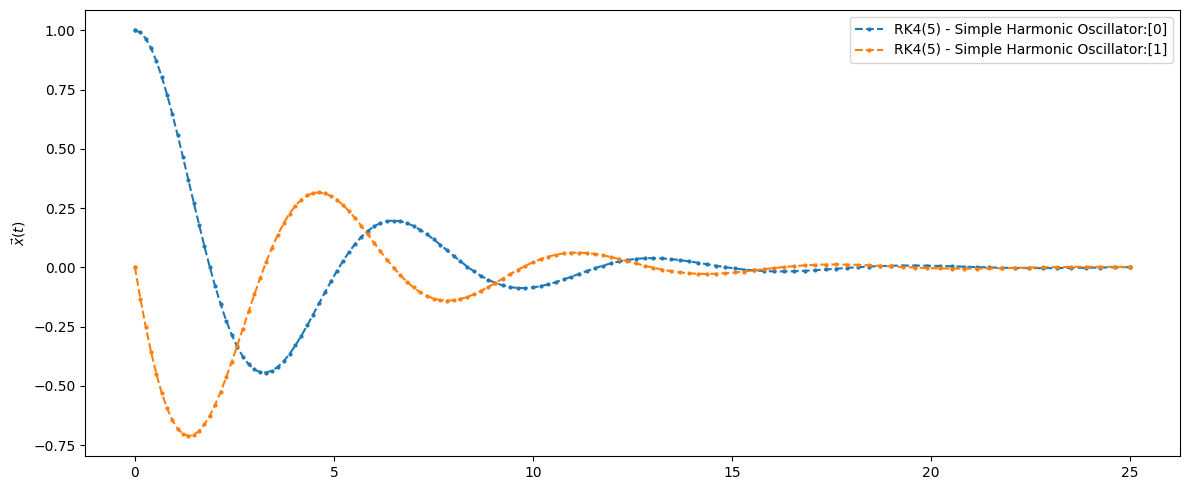

In [14]:
fig, axes = neuralode.plot.trajectory.plot_trajectory(sha_states, method_label="RK4(5) - Simple Harmonic Oscillator")

Excellent! We can see that we've implemented the oscillator correctly, and it is oscillating and decaying as expected. Now, let's try something interesting with this, let's assume we don't know the frequency and the damping factor, but we do know the initial state, and we would like to estimate the frequency/damping based on the previously computed trajectory.

This requires splitting the problem into several parts:
* First, we must integrate our system with the guesses to each point in time that we've solved the system above.
* Second, we must compute an error at each point in time
* Third, we must compute the gradients of the error with respect to our parameters
* Fourth, we must update our parameters based on the gradients

We'll write the code for the first part, essentially we'll create a few parameters that we'll be optimising

In [15]:
# You'll note that we set requires_grad=True to let PyTorch know that we want to track the operations
# involving these variables and compute their gradients
optimised_frequency = torch.tensor(0.1, requires_grad=True)
optimised_damping = torch.tensor(1.0, requires_grad=True)

Second, we'll need to write some code that integrates our values piecewise to each point in time we're interested in:

In [16]:
times_to_integrate = [time for _, time in sha_states][1:]
# We skip the first time as we know the initial state
current_state = initial_x.clone()
current_time  = initial_time.clone()

## DETAIL THE ERROR FUNCTION AND HOW THAT'S USED
# Let's look at the first sample_time and see what output we get
for sample_index, sample_time in enumerate(times_to_integrate[:1]):
    (current_state, current_time), _, _ = adaptive_rk45_integrator.apply(sha_dynamics, current_state, current_time, sample_time, dt, atol, rtol, optimised_frequency, optimised_damping)
    error = torch.linalg.norm(sha_states[sample_index][0] - current_state)
    print(f"The current state: {current_state}")
    print(f"Error at time {current_time} is {error}")

The current state: tensor([ 1.0000e+00, -4.9998e-06])
Error at time 0.0005 is 4.999750162497297e-06


Now let's look at how pytorch represents operations whose gradients is `taped`:

In [17]:
optimised_frequency*2

tensor(0.2000, grad_fn=<MulBackward0>)

It seems that the output from our integrator is missing the appropriate `grad_fn` which should point to our integrator. Looking into the documentation and reading [this issue](https://github.com/pytorch/pytorch/issues/55509) we see that `torch.autograd.Function` requires outputs to be flat tensors and not nested inside python structures like lists and tuples. This means we need to rework our code so that the output is compatible with PyTorch's gradient tracking. 

In [18]:
def get_integrator(integrator_tableau: torch.Tensor, integrator_order: int, use_local_extrapolation: bool = True, integrator_name: str = None) -> torch.autograd.Function:
    # We look at the first column of the last two rows, and if both are `inf`, we know the method is adaptive
    is_adaptive = torch.isinf(integrator_tableau[-1,0]) and torch.isinf(integrator_tableau[-2,0])
    # The number of stages is the number of rows minus the last row
    # (or last two rows if the method is adaptive)
    number_of_stages = integrator_tableau.shape[0] - 1
    if is_adaptive:
        number_of_stages -= 1
    # The `type` function in this form works to dynamically create a class
    # the first parameter is the class name, the second are parent classes,
    # and the last are the class attributes. We store the integrator attributes 
    # here, and reference them in the integration code.
    # In this way, we can query these parameters at a future point.
    __integrator_type = type(integrator_name, (torch.autograd.Function,), {
        "integrator_tableau": integrator_tableau,
        "integrator_order": integrator_order,
        "is_adaptive": is_adaptive,
        "number_of_stages": number_of_stages
    })
    def __internal_forward(ctx, fn: typing.Callable[[torch.Tensor, torch.Tensor, typing.Any], torch.Tensor], 
                           x0: torch.Tensor, t0: torch.Tensor, t1: torch.Tensor, dt: torch.Tensor,
                           atol: torch.Tensor, rtol: torch.Tensor, *additional_dynamic_args):
        """
        A general integration routine for solving an Initial Value Problem
        using any arbitrary Butcher Tableau
        
        Instead of naively summing the changes, we use compensated summation.
        
        :param fn: the function to be integrated
        :param initial_state: the initial state to integrate from
        :param initial_time: the initial time to integrate from
        :param final_time: the final time to integrate to
        :param timestep: the time increments to integrate with
        :param atol: The absolute tolerance for the error in an adaptive integration
        :param rtol: The relative tolerance for the error in an adaptive integration
        :param additional_dynamic_args: additional arguments to pass to the function
        :return: a tuple of ((the final state, the final time), the intermediate states [list[torch.Tensor]], the error values [list[torch.Tensor]]) 
        """        
        if __integrator_type.is_adaptive:
            # We need to check that both `atol` and `rtol` are valid values and are compatible with the state
            atol = torch.abs(atol) # Need to ensure that the tolerance is a strictly positive number
            if atol.dim() != 0:
                # We can set per-component tolerances, but that means that the shapes of x0 and atol/rtol are compatible.
                # To test this, we try to add the tolerance to the initial state and check for errors
                try:
                    _ = x0.clone() + atol.clone()
                except RuntimeError:
                    raise ValueError(f"Expected shape of x0 and atol to be compatible, got {x0.shape} and {atol.shape} respectively")
            # 
            if torch.any((atol < torch.finfo(x0.dtype).eps) & (atol != 0.0)):
                # If any component of `atol` is too small, we adjust the values to be compatible with the datatype
                # To preserve differentiability, we divide out the detached value of `atol` and multiply by the epsilon 
                warnings.warn(f"Absolute tolerance is too small for tensor dtype: {x0.dtype}. Set atol={torch.finfo(x0.dtype).eps}.")
                atol = torch.where((atol < torch.finfo(x0.dtype).eps) & (atol != 0.0), (atol/atol.detach())*torch.finfo(x0.dtype).eps, atol) 
            elif torch.any(atol < torch.finfo(x0.dtype).eps**0.5):
                # When the tolerances are tiny (roughly eps^0.5), truncation error can start to dominate
                # while we are compensating for this using Kahan summation, the user should be informed that this may cause issues.
                warnings.warn(f"Absolute tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error")
            rtol = torch.abs(rtol) # Need to ensure that the tolerance is a strictly positive number
            if rtol.dim() != 0:
                # We can set per-component tolerances, but that means that the shapes of x0 and atol/rtol are compatible.
                # To test this, we try to add the tolerance to the 
                try:
                    _ = x0.clone() + rtol.clone()
                except RuntimeError:
                    raise ValueError(f"Expected shape of x0 and rtol to be compatible, got {x0.shape} and {rtol.shape} respectively")
            # 
            if torch.any((rtol < torch.finfo(x0.dtype).eps) & (rtol != 0.0)):
                # If any component of `rtol` is too small, we adjust the values to be compatible with the datatype
                # To preserve differentiability, we divide out the detached value of `rtol` and multiply by the epsilon 
                warnings.warn(f"Relative tolerance is too small for tensor dtype: {x0.dtype}. Set rtol={torch.finfo(x0.dtype).eps}.")
                rtol = torch.where((rtol < torch.finfo(x0.dtype).eps) & (rtol != 0.0), (rtol/rtol.detach())*torch.finfo(x0.dtype).eps, rtol) 
            elif torch.any(rtol < torch.finfo(x0.dtype).eps**0.5):
                # When the tolerances are tiny (roughly eps^0.5), truncation error can start to dominate
                # while we are compensating for this using Kahan summation, the user should be informed that this may cause issues.
                warnings.warn(f"Relative tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error")
        
        if torch.any(torch.sign(t1 - t0) != torch.sign(dt)):
            # When dt points in a different direction to the direction of integration, this will cause issues in our integration loop
            # we either correct this or raise an error, we've elected to resolve this silently
            warnings.warn(f"Different sign of (t1 - t0) and dt: {t1 - t0} and {dt}, correcting...")
            dt = torch.copysign(dt, t1 - t0)            
        
        c_state = x0.clone()
        c_time = t0.clone()
        
        # Instead of storing each (x,t) pair in a list, we'll store them in separate tensors
        intermediate_states = [c_state.clone()]
        intermediate_times = [c_time.clone()]
        
        butcher_tableau = __integrator_type.integrator_tableau.clone().to(x0.device, x0.dtype)
        error_in_state = [torch.zeros(tuple(), device=x0.device, dtype=x0.dtype)]

        def compute_step(state, time, step):
            # We need to store the intermediate stages
            k_stages = torch.stack([torch.zeros_like(c_state)]*__integrator_type.number_of_stages)
            # we subtract one since the last row is the final state
            for stage_index in range(__integrator_type.number_of_stages):
                c_coeff, *a_coeff = butcher_tableau[stage_index]
                k_stages[stage_index] = fn(
                    # We use `compensated_sum` instead of `sum` to avoid truncation at each stage calculation
                    state + step * neuralode.util.compensated_sum(k*a for k,a in zip(k_stages, a_coeff)), 
                    time + c_coeff * step,
                    *additional_dynamic_args
                )
            lower_order_estimate = step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-1, 1:]))
            # To have a valid value, we set `higher_order_estimate` to the same value as `lower_order_estimate`
            # Further down, this will simplify the code as we won't have to account for invalid values 
            higher_order_estimate = lower_order_estimate
            if __integrator_type.is_adaptive:
                higher_order_estimate = step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-2, 1:]))
            # From a numerical perspective, this implementation is not necessarily ideal as
            # we can lose precision when subtracting the two solutions. A more numerically accurate
            # implementation would have one row `b_i` coefficients and another row the coefficients
            # for computing the error directly
            return lower_order_estimate, higher_order_estimate, step
        
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(c_state)
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(c_time)
        
        while torch.any((c_time + dt) < t1):
            delta_state_lower, delta_state_upper, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, dt)
            # If local extrapolation is enabled, we take the higher order estimate, otherwise the lower order one
            delta_state = delta_state_upper if use_local_extrapolation else delta_state_lower
            
            # We use `torch.linalg.norm` to compute the magnitude of the error
            # we can adjust this by passing in the `ord` keyword to choose a different
            # vector norm, but the 2-norm suffices for our purposes
            error_in_state.append(torch.linalg.norm(delta_state_upper - delta_state_lower))
            if __integrator_type.is_adaptive:
                # To save on computation, we only compute the max error tolerated and the step 
                # correction when the method is adaptive
                max_error = atol + torch.linalg.norm(rtol * c_state)
                step_correction = 0.8*torch.where(error_in_state[-1] != 0.0, max_error/error_in_state[-1], 1.0)**(1/integrator_order)
                # Based on the error, we correct the step size
                dt = step_correction*dt
                if error_in_state[-1] >= max_error:
                    # If the error exceeds our error threshold, we don't commit the step and redo it
                    error_in_state = error_in_state[:-1]
                    continue
            c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
            c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
            
            intermediate_states.append(c_state + truncated_bits_state)
            intermediate_times.append(c_time + truncated_bits_time)
            
        delta_state_lower, delta_state_upper, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, (t1 - c_time) - truncated_bits_time)
        delta_state = delta_state_upper if use_local_extrapolation else delta_state_lower
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
            
        error_in_state.append(torch.linalg.norm(delta_state_upper - delta_state_lower))
        
        intermediate_states.append(c_state + truncated_bits_state)
        intermediate_times.append(c_time + truncated_bits_time)
        
        # As we said, these need to be converted to tensors for proper tracking
        intermediate_states = torch.stack(intermediate_states, dim=0)
        intermediate_times = torch.stack(intermediate_times, dim=0)
        
        # We should also put the errors we're returning into a tensor too
        error_in_state = torch.stack(error_in_state, dim=0)
        
        # We save parameters for the backward pass, but these won't be used 
        # until we implement the adjoint method for backpropagation
        ctx.save_for_backward(c_state, c_time, intermediate_states, intermediate_times, *additional_dynamic_args)
        ctx.integration_function = fn
        
        # Now we're returning a flat structure where each element is a tensor, and so its gradients can be properly tracked
        return c_state, c_time, intermediate_states, intermediate_times, error_in_state
    
    if not __integrator_type.is_adaptive:
        # If the method isn't adaptive, neither atol nor rtol are required, but because of
        # how `torch.autograd.Function` works, we cannot have keyword arguments
        # For that reason, we use an alternative implementation to fill those values with a stub
        def __internal_forward_nonadaptive(ctx, fn: typing.Callable[[torch.Tensor, torch.Tensor, typing.Any], torch.Tensor], 
                                           x0: torch.Tensor, t0: torch.Tensor, t1: torch.Tensor, dt: torch.Tensor, *additional_dynamic_args):
            return __internal_forward(ctx, fn, x0, t0, t1, dt, torch.inf, torch.inf, *additional_dynamic_args)
        __integrator_type.forward = staticmethod(__internal_forward_nonadaptive)
    else:
        __integrator_type.forward = staticmethod(__internal_forward)
    return __integrator_type

In [19]:
adaptive_rk45_integrator = get_integrator(adaptive_rk45_integrator.integrator_tableau, integrator_order = 5, use_local_extrapolation = False, integrator_name = "AdaptiveRK45Integrator")

times_to_integrate = [time for _, time in sha_states][1:]
# We skip the first time as we know the initial state
current_state = initial_x.clone()
current_time  = initial_time.clone()
error = 0.0

# Let's look at the first sample_time and see what output we get
for sample_index, sample_time in enumerate(times_to_integrate[:1]):
    current_state, current_time, *_ = adaptive_rk45_integrator.apply(sha_dynamics, current_state, current_time, sample_time, dt, atol, rtol, optimised_frequency, optimised_damping)
    error = error + torch.linalg.norm(sha_states[sample_index][0] - current_state)/len(times_to_integrate)
    print(f"The current state: {current_state}")
    print(f"Error at time {current_state} is {error}")

The current state: tensor([ 1.0000e+00, -4.9998e-06], grad_fn=<AdaptiveRK45IntegratorBackward>)
Error at time tensor([ 1.0000e+00, -4.9998e-06], grad_fn=<AdaptiveRK45IntegratorBackward>) is 4.03205658265911e-08


Excellent! We now see that pytorch is correctly tracking our integration as part of the gradient tape. Let's try computing the gradients!

In [20]:
try:
    error.backward()
except NotImplementedError as e:
    print(f"Encountered exception: {e}")

Encountered exception: You must implement either the backward or vjp method for your custom autograd.Function to use it with backward mode AD.


Ah yes, we haven't implemented a backward method yet so let's do that:

In [21]:
def get_integrator(integrator_tableau: torch.Tensor, integrator_order: int, use_local_extrapolation: bool = True, integrator_name: str = None) -> torch.autograd.Function:
    # We look at the first column of the last two rows, and if both are `inf`, we know the method is adaptive
    is_adaptive = torch.isinf(integrator_tableau[-1,0]) and torch.isinf(integrator_tableau[-2,0])
    # The number of stages is the number of rows minus the last row
    # (or last two rows if the method is adaptive)
    number_of_stages = integrator_tableau.shape[0] - 1
    if is_adaptive:
        number_of_stages -= 1
    # The `type` function in this form works to dynamically create a class
    # the first parameter is the class name, the second are parent classes,
    # and the last are the class attributes. We store the integrator attributes 
    # here, and reference them in the integration code.
    # In this way, we can query these parameters at a future point.
    __integrator_type = type(integrator_name, (torch.autograd.Function,), {
        "integrator_tableau": integrator_tableau,
        "integrator_order": integrator_order,
        "is_adaptive": is_adaptive,
        "number_of_stages": number_of_stages
    })
    def __internal_forward(ctx, fn: typing.Callable[[torch.Tensor, torch.Tensor, typing.Any], torch.Tensor], 
                           x0: torch.Tensor, t0: torch.Tensor, t1: torch.Tensor, dt: torch.Tensor,
                           atol: torch.Tensor, rtol: torch.Tensor, *additional_dynamic_args):
        """
        A general integration routine for solving an Initial Value Problem
        using any arbitrary Butcher Tableau
        
        Instead of naively summing the changes, we use compensated summation.
        
        :param fn: the function to be integrated
        :param initial_state: the initial state to integrate from
        :param initial_time: the initial time to integrate from
        :param final_time: the final time to integrate to
        :param timestep: the time increments to integrate with
        :param atol: The absolute tolerance for the error in an adaptive integration
        :param rtol: The relative tolerance for the error in an adaptive integration
        :param additional_dynamic_args: additional arguments to pass to the function
        :return: a tuple of ((the final state, the final time), the intermediate states [list[torch.Tensor]], the error values [list[torch.Tensor]]) 
        """
        if __integrator_type.is_adaptive:
            # We need to check that both `atol` and `rtol` are valid values and are compatible with the state
            atol = torch.abs(atol) # Need to ensure that the tolerance is a strictly positive number
            if atol.dim() != 0:
                # We can set per-component tolerances, but that means that the shapes of x0 and atol/rtol are compatible.
                # To test this, we try to add the tolerance to the initial state and check for errors
                try:
                    _ = x0.clone() + atol.clone()
                except RuntimeError:
                    raise ValueError(f"Expected shape of x0 and atol to be compatible, got {x0.shape} and {atol.shape} respectively")
            # 
            if torch.any((atol < torch.finfo(x0.dtype).eps) & (atol != 0.0)):
                # If any component of `atol` is too small, we adjust the values to be compatible with the datatype
                # To preserve differentiability, we divide out the detached value of `atol` and multiply by the epsilon 
                warnings.warn(f"Absolute tolerance is too small for tensor dtype: {x0.dtype}. Set atol={torch.finfo(x0.dtype).eps}.", RuntimeWarning)
                atol = torch.where((atol < torch.finfo(x0.dtype).eps) & (atol != 0.0), (atol/atol.detach())*torch.finfo(x0.dtype).eps, atol) 
            elif torch.any(atol < torch.finfo(x0.dtype).eps**0.5):
                # When the tolerances are tiny (roughly eps^0.5), truncation error can start to dominate
                # while we are compensating for this using Kahan summation, the user should be informed that this may cause issues.
                warnings.warn(f"Absolute tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error", RuntimeWarning)
            rtol = torch.abs(rtol) # Need to ensure that the tolerance is a strictly positive number
            if rtol.dim() != 0:
                # We can set per-component tolerances, but that means that the shapes of x0 and atol/rtol are compatible.
                # To test this, we try to add the tolerance to the 
                try:
                    _ = x0.clone() + rtol.clone()
                except RuntimeError:
                    raise ValueError(f"Expected shape of x0 and rtol to be compatible, got {x0.shape} and {rtol.shape} respectively")
            # 
            if torch.any((rtol < torch.finfo(x0.dtype).eps) & (rtol != 0.0)):
                # If any component of `rtol` is too small, we adjust the values to be compatible with the datatype
                # To preserve differentiability, we divide out the detached value of `rtol` and multiply by the epsilon 
                warnings.warn(f"Relative tolerance is too small for tensor dtype: {x0.dtype}. Set rtol={torch.finfo(x0.dtype).eps}.", RuntimeWarning)
                rtol = torch.where((rtol < torch.finfo(x0.dtype).eps) & (rtol != 0.0), (rtol/rtol.detach())*torch.finfo(x0.dtype).eps, rtol) 
            elif torch.any(rtol < torch.finfo(x0.dtype).eps**0.5):
                # When the tolerances are tiny (roughly eps^0.5), truncation error can start to dominate
                # while we are compensating for this using Kahan summation, the user should be informed that this may cause issues.
                warnings.warn(f"Relative tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error", RuntimeWarning)
        
        if torch.any(torch.abs(t1 - t0) < torch.abs(dt)):
            dt = (dt/dt.detach())*torch.abs(t1 - t0)
        
        if torch.any(torch.sign(t1 - t0) != torch.sign(dt)):
            # When dt points in a different direction to the direction of integration, this will cause issues in our integration loop
            # we either correct this or raise an error, we've elected to resolve this silently
            warnings.warn(f"Different sign of (t1 - t0) and dt: {t1 - t0} and {dt}, correcting...", RuntimeWarning)
            dt = torch.copysign(dt, t1 - t0)            
        
        c_state = x0.clone()
        c_time = t0.clone()
        
        # Instead of storing each (x,t) pair in a list, we'll store them in separate tensors
        intermediate_states = [c_state.clone()]
        intermediate_times = [c_time.clone()]
        
        butcher_tableau = __integrator_type.integrator_tableau.clone().to(x0.device, x0.dtype)
        error_in_state = [torch.zeros(tuple(), device=x0.device, dtype=x0.dtype)]

        def compute_step(state, time, step):
            # We need to store the intermediate stages
            k_stages = torch.stack([torch.zeros_like(c_state)]*__integrator_type.number_of_stages)
            # we subtract one since the last row is the final state
            for stage_index in range(__integrator_type.number_of_stages):
                c_coeff, *a_coeff = butcher_tableau[stage_index]
                k_stages[stage_index] = fn(
                    # We use `compensated_sum` instead of `sum` to avoid truncation at each stage calculation
                    state + step * neuralode.util.compensated_sum(k*a for k,a in zip(k_stages, a_coeff)), 
                    time + c_coeff * step,
                    *additional_dynamic_args
                ) 
            lower_order_estimate = step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-1, 1:]))
            # To have a valid value, we set `higher_order_estimate` to the same value as `lower_order_estimate`
            # Further down, this will simplify the code as we won't have to account for invalid values 
            higher_order_estimate = lower_order_estimate
            if __integrator_type.is_adaptive:
                higher_order_estimate = step * neuralode.util.compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-2, 1:]))
            # From a numerical perspective, this implementation is not necessarily ideal as
            # we can lose precision when subtracting the two solutions. A more numerically accurate
            # implementation would have one row `b_i` coefficients and another row the coefficients
            # for computing the error directly
            return lower_order_estimate, higher_order_estimate, step
        
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(c_state)
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(c_time)
        
        while torch.any((c_time + dt) < t1):
            delta_state_lower, delta_state_upper, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, dt)
            # If local extrapolation is enabled, we take the higher order estimate, otherwise the lower order one
            delta_state = delta_state_upper if use_local_extrapolation else delta_state_lower

            # We use `torch.linalg.norm` to compute the magnitude of the error
            # we can adjust this by passing in the `ord` keyword to choose a different
            # vector norm, but the 2-norm suffices for our purposes
            error_in_state.append(torch.linalg.norm(delta_state_upper - delta_state_lower))
            if __integrator_type.is_adaptive:
                # To save on computation, we only compute the max error tolerated and the step 
                # correction when the method is adaptive
                max_error = atol + torch.linalg.norm(rtol * c_state)
                step_correction = 0.8*torch.where(error_in_state[-1] != 0.0, max_error/error_in_state[-1], 1.0)**(1/integrator_order)
                # Based on the error, we correct the step size
                dt = step_correction.detach()*dt
                if error_in_state[-1].detach() >= max_error.detach():
                    # If the error exceeds our error threshold, we don't commit the step and redo it
                    error_in_state = error_in_state[:-1]
                    continue
            c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
            c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
            
            intermediate_states.append(c_state + truncated_bits_state)
            intermediate_times.append(c_time + truncated_bits_time)
            
        delta_state_lower, delta_state_upper, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, (t1 - c_time) - truncated_bits_time)
        delta_state = delta_state_upper if use_local_extrapolation else delta_state_lower
        c_state, truncated_bits_state = neuralode.util.partial_compensated_sum(delta_state, (c_state, truncated_bits_state))
        c_time,  truncated_bits_time  = neuralode.util.partial_compensated_sum(delta_time, (c_time, truncated_bits_time))
            
        error_in_state.append(torch.linalg.norm(delta_state_upper - delta_state_lower))
        
        intermediate_states.append(c_state + truncated_bits_state)
        intermediate_times.append(c_time + truncated_bits_time)
        
        # As we said, these need to be converted to tensors for proper tracking
        intermediate_states = torch.stack(intermediate_states, dim=0)
        intermediate_times = torch.stack(intermediate_times, dim=0)
        
        # We should also put the errors we're returning into a tensor too
        error_in_state = torch.stack(error_in_state, dim=0)
        
        if ctx is not None:
            # We save parameters for the backward pass, but these won't be used 
            # until we implement the adjoint method for backpropagation
            ctx.mark_non_differentiable(t0, t1, atol, rtol, dt)
            ctx.save_for_backward(x0, t0, t1, dt, atol, rtol, c_state, c_time, intermediate_states, intermediate_times, *additional_dynamic_args)
            ctx.__integration_fn = fn
        
        # Now we're returning a flat structure where each element is a tensor, and so its gradients can be properly tracked
        return c_state, c_time, intermediate_states, intermediate_times, error_in_state
    
    def __internal_backward(ctx, d_c_state, d_c_time, d_intermediate_states, d_intermediate_times, d_error_in_state):
        """
        This function computes the gradient of the input variables for `__internal_forward` by exploiting the fact
        that PyTorch can track the whole graph of operations used to derive a specific result. Thus each time backward is called,
        we compute the actual graph of operations and propagate derivatives through it. Unfortunately, this is an exceptionally
        slow method of computation that also uses a lot of memory.
        
        This is implemented here as a demonstration of how we could compute gradients and how these are expected to be propagated back
        to the autograd tape. 
        
        :param ctx: 
        :param d_c_state: 
        :param d_c_time: 
        :param d_intermediate_states: 
        :param d_intermediate_times: 
        :param d_error_in_state: 
        :return: 
        """
        
        # First we retrieve our integration function that we stored in `__internal_forward`
        fn = ctx.__integration_fn
        # Then we retrieve the input variables and clone them to avoid influencing them in the later operations
        x0, t0, t1, dt, atol, rtol, _, _, _, _, *additional_dynamic_args = [i.clone().requires_grad_(True) for i in ctx.saved_tensors]
        inputs = fn, x0, t0, t1, dt, atol, rtol, *additional_dynamic_args        
        if any(ctx.needs_input_grad):
            # We ensure that gradients are enabled so that autograd tracks the variable operations 
            with torch.enable_grad():
                # And then we integrate our system with the tracking of operations.
                # We pass in `None` for the `ctx` to avoid issues with __internal_forward attempting to call methods that we don't want to use
                # In the adjoint method, this will not be an issue
                c_state, c_time, intermediate_states, intermediate_times, error_in_state = __internal_forward(None, fn, x0, t0, t1, dt, atol, rtol, *additional_dynamic_args)
            # We collate the outputs that we can compute gradients for
            # with this method, we are restricted to the final state and time
            # as the result of the integration isn't entirely deterministic
            # TODO: Figure out why
            outputs = c_state, c_time #, intermediate_states, intermediate_times, error_in_state
            grad_outputs = d_c_state, d_c_time, d_intermediate_states, d_intermediate_times, d_error_in_state
            
            # We also only consider the input and output variables that actually have gradients enabled
            inputs_with_grad = [i for idx, i in enumerate(inputs) if ctx.needs_input_grad[idx]]
            outputs_with_grad = [idx for idx, i in enumerate(outputs) if i.grad_fn is not None]
            
            grad_of_inputs_with_grad = torch.autograd.grad([outputs[idx] for idx in outputs_with_grad], inputs_with_grad, grad_outputs=[grad_outputs[idx] for idx in outputs_with_grad], allow_unused=True, materialize_grads=True)
        else:
            grad_of_inputs_with_grad = None
        # For each input we must return a gradient
        # Interestingly, this also includes the function we passed in...
        # We create a list of None values 
        # (this tells autograd that there is no gradient for those variables).
        # And for each variable that does have a gradient, we fill the values in
        # before returning the list
        input_grads = [None for _ in range(len(inputs))]
        if grad_of_inputs_with_grad:
            for idx in range(len(inputs)):
                if ctx.needs_input_grad[idx]:
                    input_grads[idx], *grad_of_inputs_with_grad = grad_of_inputs_with_grad
        return tuple(input_grads)
            
    
    if not __integrator_type.is_adaptive:
        # If the method isn't adaptive, neither atol nor rtol are required, but because of
        # how `torch.autograd.Function` works, we cannot have keyword arguments
        # For that reason, we use an alternative implementation to fill those values with a stub
        def __internal_forward_nonadaptive(ctx, fn: typing.Callable[[torch.Tensor, torch.Tensor, typing.Any], torch.Tensor], 
                                           x0: torch.Tensor, t0: torch.Tensor, t1: torch.Tensor, dt: torch.Tensor, *additional_dynamic_args):
            return __internal_forward(ctx, fn, x0, t0, t1, dt, torch.inf, torch.inf, *additional_dynamic_args)
        __integrator_type.forward = staticmethod(__internal_forward_nonadaptive)
    else:
        __integrator_type.forward = staticmethod(__internal_forward)
    __integrator_type.backward = staticmethod(__internal_backward)
    return __integrator_type

In [22]:
adaptive_rk45_integrator = get_integrator(adaptive_rk45_integrator.integrator_tableau, integrator_order = 5, use_local_extrapolation = False, integrator_name = "AdaptiveRK45Integrator")

times_to_integrate = [time for _, time in sha_states][1:]
# We skip the first time as we know the initial state
current_state = initial_x.clone()
current_time  = initial_time.clone()

error = 0.0

# Let's look at the first sample_time and see what output we get
for sample_index, sample_time in enumerate(times_to_integrate[:1]):
    current_state, current_time, *_ = adaptive_rk45_integrator.apply(sha_dynamics, current_state, current_time, sample_time, dt, atol, rtol, optimised_frequency, optimised_damping)
    error = error + torch.linalg.norm(sha_states[sample_index][0] - current_state)/len(times_to_integrate)
    print(f"The current state: {current_state}")
    print(f"Error at time {current_state} is {error}")
error.backward()

The current state: tensor([ 1.0000e+00, -4.9998e-06], grad_fn=<AdaptiveRK45IntegratorBackward>)
Error at time tensor([ 1.0000e+00, -4.9998e-06], grad_fn=<AdaptiveRK45IntegratorBackward>) is 4.03205658265911e-08


In [23]:
print(f"Current Frequency: {optimised_frequency}, Frequency grad: {optimised_frequency.grad}")
print(f"Current Damping: {optimised_damping}, Damping grad: {optimised_damping.grad}")

Current Frequency: 0.1, Frequency grad: 8.063911562493276e-07
Current Damping: 1.0, Damping grad: -2.0159946488567326e-12


Great, we see that the gradient of both `optimised_frequency` and `optimised_damping` have been populated. Let's check that this gradient is being computed correctly using `torch.autograd.gradcheck` with random initial conditions, frequencies and damping coefficients. In this way, we can check that the gradient is correct across multiple conditions. 

`gradcheck` works by using finite differences as the numerical value and comparing that to the autodiff derived value for the gradient (or, more generally, the Jacobian). This requires multiple numerical integrations and running at the highest precision possible (hence the use of `atol**2` and `rtol**2` which achieves machine precision) to ensure that numerical inaccuracy is not the cause of incorrect gradients. This is quite an expensive procedure due to the depth of the autodiff graph that is generated and thus will take some time to compute.

In [24]:
from torch.autograd import gradcheck

def test_func(init_state, freq, damp):
    res = adaptive_rk45_integrator.apply(sha_dynamics, init_state, initial_time, final_time, dt, atol**2, rtol**2, freq, damp)
    return res[0]

test_variables = [initial_x, frequency, damping]

def generate_test_vars():
    test_x = (2*torch.rand_like(initial_x) - 1.0)*2.0
    test_frequency = torch.rand_like(frequency)*5.0
    test_damping = torch.rand_like(damping)
    return [i.requires_grad_(True) for i in [test_x, test_frequency, test_damping]]

with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    num_tests = 4
    print(f"[0/{num_tests}] - vars: {[i.detach().cpu().tolist() for i in test_variables]}, success: ", end='')
    print(gradcheck(test_func, [i.detach().clone().requires_grad_(True) for i in test_variables]))
    for iter_idx in range(num_tests):
        variables = generate_test_vars()
        print(f"[{iter_idx+1}/{num_tests}] - vars: {[i.detach().cpu().tolist() for i in variables]}, success: ", end='')
        print(gradcheck(test_func, variables))

[0/4] - vars: [[1.0, 0.0], 1.0, 0.25], success: True
[1/4] - vars: [[1.921323407609818, -1.0682648845284293], 1.6717766516680115, 0.49507008177546674], success: True
[2/4] - vars: [[-0.8024927433637736, -1.6161882802737901], 1.8656705227745485, 0.19364099777829757], success: True
[3/4] - vars: [[-0.1598046591589033, -0.7063480873980632], 4.019660703696356, 0.20975291947734453], success: True
[4/4] - vars: [[-0.5528332642016722, -1.4199646384377012], 2.794785048828933, 0.04872074299818019], success: True


Now that we've validated the correctness of the gradients, we can implement an optimisation loop to fit our parameters to a prior trajectory.

In [25]:
times_to_integrate = [time for _, time in sha_states][1:]
# We skip the first time as we know the initial state

# We reinitialise our variables
optimised_frequency = torch.tensor(0.1, requires_grad=True)
optimised_damping = torch.tensor(1.0, requires_grad=True)
# As damping needs to be a strictly positive quantity, we log-encode it
log_encoded_damping = torch.log(optimised_damping.detach()).requires_grad_(True)

# First, we'll create an `optimiser` following pytorch convention
optimiser = torch.optim.Adam([optimised_frequency, log_encoded_damping], lr=1e-2, amsgrad=True)

# Next, we'll define a closure function whose sole purpose is to
# zero the gradients and compute the error. This is useful as it allows switching to other
# optimisers such as LBFGS or anything that re-evaluates the error without
# computing its gradient
def sha_closure():
    current_state = initial_x.clone()
    current_time  = initial_time.clone()
    optimiser.zero_grad()
    error = 0.0
    
    for sample_index, sample_time in enumerate(times_to_integrate):
        # We don't require high precision here as this system, with the parameters we've set is fairly stable
        # We only need that the gradients have the right direction and roughly the right magnitude to do gradient descent
        new_state, new_time, *_ = adaptive_rk45_integrator.apply(sha_dynamics, current_state, current_time, sample_time, torch.minimum(dt, sample_time - current_time), atol, rtol, optimised_frequency, torch.exp(log_encoded_damping))
        error = error + torch.linalg.norm(sha_states[sample_index][0] - new_state)/len(times_to_integrate)
        current_state, current_time = new_state.detach(), new_time.detach()
    if error.requires_grad:
        error.backward()
    return error

# Now we need an optimisation `loop` where we will take steps to minimise the error
number_of_gd_steps = 256

# We also need to track the best solution thus far
best_error = torch.inf
best_frequency, best_damping = optimised_frequency.detach().clone(), optimised_damping.detach().clone()
for step in range(number_of_gd_steps):
    step_error = optimiser.step(sha_closure)
    if step_error < best_error:
        best_error = step_error.item()
        best_frequency = optimised_frequency.detach().clone()
        best_damping = torch.exp(log_encoded_damping.detach().clone())
    print(f"[{step+1}/{number_of_gd_steps}] Error: {step_error.item():.6f}, Current Frequency: {optimised_frequency.item():.6f}, Current Damping: {torch.exp(log_encoded_damping).item():.6f}")
    
print(f"Best frequency: {best_frequency.item():.6f}, relative error: {torch.mean(torch.abs(1 - best_frequency / frequency)).item():.6%}")
print(f"Best damping:   {best_damping.item():.6f}, relative error: {torch.mean(torch.abs(1 - best_damping / damping)).item():.6%}")

[1/256] Error: 0.718138, Current Frequency: 0.110000, Current Damping: 0.990051
[2/256] Error: 0.686355, Current Frequency: 0.120008, Current Damping: 0.980191
[3/256] Error: 0.655750, Current Frequency: 0.130027, Current Damping: 0.970422
[4/256] Error: 0.626408, Current Frequency: 0.140062, Current Damping: 0.960753
[5/256] Error: 0.598379, Current Frequency: 0.150117, Current Damping: 0.951206
[6/256] Error: 0.571688, Current Frequency: 0.160195, Current Damping: 0.941820
[7/256] Error: 0.546343, Current Frequency: 0.170300, Current Damping: 0.932656
[8/256] Error: 0.522344, Current Frequency: 0.180436, Current Damping: 0.923802
[9/256] Error: 0.499689, Current Frequency: 0.190608, Current Damping: 0.915383
[10/256] Error: 0.478377, Current Frequency: 0.200820, Current Damping: 0.907575
[11/256] Error: 0.458415, Current Frequency: 0.211077, Current Damping: 0.900601
[12/256] Error: 0.439823, Current Frequency: 0.221385, Current Damping: 0.894715
[13/256] Error: 0.422625, Current Fre

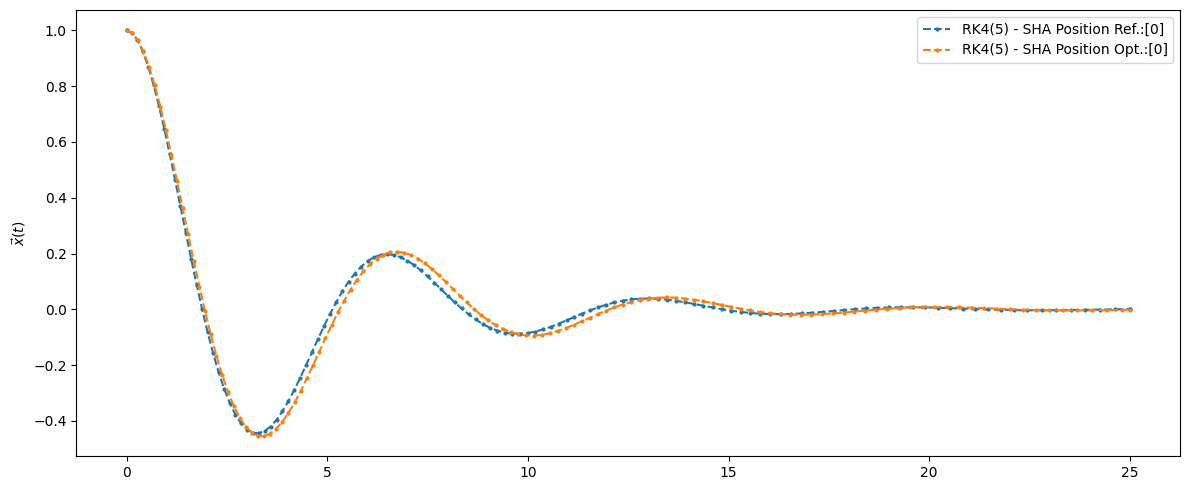

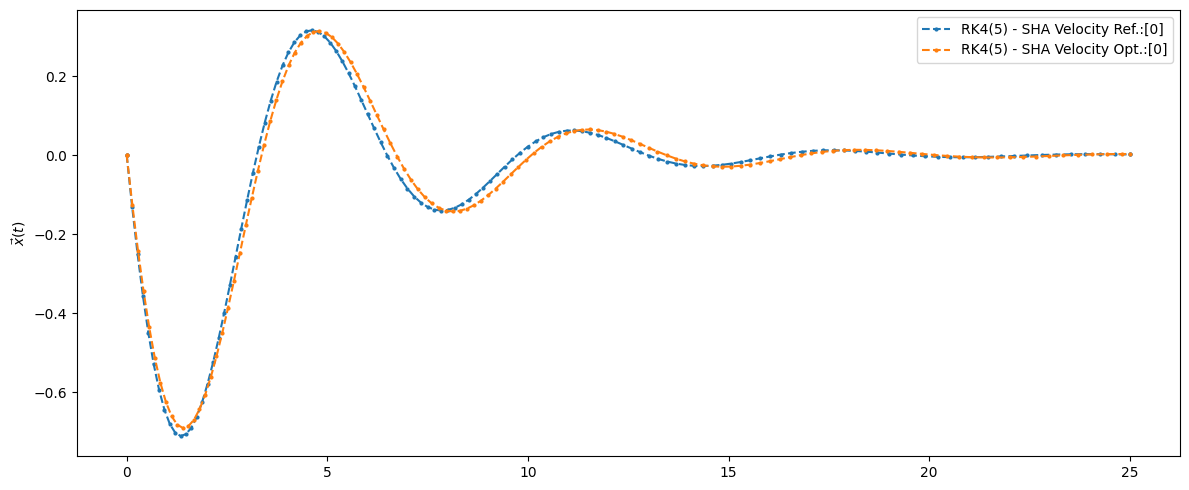

In [26]:
_, _, sha_states_ref, sha_times_ref, _ = adaptive_rk45_integrator.apply(sha_dynamics, initial_x, initial_time, final_time, dt, atol, rtol, frequency, damping)
fig_ref_position, axes_ref_position = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Position Ref.")
fig_ref_velocity, axes_ref_velocity = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Velocity Ref.")

_, _, sha_states_optimised, sha_times_optimised, _ = adaptive_rk45_integrator.apply(sha_dynamics, initial_x, initial_time, final_time, dt, atol, rtol, best_frequency, best_damping)
_ = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_position, method_label="RK4(5) - SHA Position Opt.")
_ = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_velocity, method_label="RK4(5) - SHA Velocity Opt.")

While we were able to infer the parameters closely through gradient descent, they are still imperfect, and you will notice that this implementation is quite slow. We could speed up some of the optimisation by using only subsets of the samples aka mini-batching at each gradient descent step.

First, we'll collate the reference states into one tensor and the reference times into another. At each iteration, we'll sample some subset and integrate the system to the appropriate times taking care to sort the integration times to avoid integrating backwards (although we could).

Second, we'll write a closure function that takes in the batch at each step and runs our previous closure routine.

In [27]:
time_dataset  = torch.stack([time for _, time in sha_states][1:])
state_dataset = torch.stack([state for state, _ in sha_states][1:])
# We skip the first time as we know the initial state

# We reinitialise our variables
optimised_frequency = torch.tensor(0.1, requires_grad=True)
optimised_damping = torch.tensor(1.0, requires_grad=True)
# As damping needs to be a strictly positive quantity, we log-encode it
log_encoded_damping = torch.log(optimised_damping.detach()).requires_grad_(True)

# First, we'll create an `optimiser` following pytorch convention
optimiser = torch.optim.Adam([optimised_frequency, log_encoded_damping], lr=1e-2, amsgrad=True)

# Next, we'll define a closure function whose sole purpose is to
# zero the gradients and compute the error. This is useful as it allows switching to other
# optimisers such as LBFGS or anything that re-evaluates the error without
# computing its gradient
def sha_closure(minibatch):
    current_state = initial_x.clone()
    current_time  = initial_time.clone()
    optimiser.zero_grad()
    error = 0.0
    
    times = minibatch['times']
    states = minibatch['states']
    
    # We need to sort both times and states simultaneously, so we'll use `argsort`
    sorted_time_indices = torch.argsort(times)
    times, states = times[sorted_time_indices], states[sorted_time_indices]
    
    for sample_state, sample_time in zip(states, times):
        new_state, new_time, *_ = adaptive_rk45_integrator.apply(sha_dynamics, current_state, current_time, sample_time, torch.minimum(dt, sample_time - current_time), atol, rtol, optimised_frequency, torch.exp(log_encoded_damping))
        error = error + torch.linalg.norm(sample_state - new_state)/times.shape[0]
        current_state, current_time = new_state, new_time
    if error.requires_grad:
        error.backward()
    return error

# We need to set the size of our mini-batches
batch_size = 16

# Now we need an optimisation `loop` where we will take steps to minimise the error
# We set the number of steps proportionally smaller to account for the fact that at each iteration
# we take `time_dataset.shape[0]//batch_size` steps instead of just 1
number_of_gd_steps = 256*batch_size//time_dataset.shape[0]

# We also need to track the best solution thus far
best_error = torch.inf
best_frequency, best_damping = optimised_frequency.detach().clone(), optimised_damping.detach().clone()
for step in range(number_of_gd_steps):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(time_dataset.shape[0])
    for batch_idx in range(0, time_dataset.shape[0], batch_size):
        batch_dict = {
            'times': time_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: sha_closure(batch_dict))
        epoch_error = epoch_error + step_error.item()*batch_dict['times'].shape[0]
        print(f"[{step+1}/{number_of_gd_steps}]/[{batch_idx}/{time_dataset.shape[0]}] Batch Error: {step_error:.6f}, Current Frequency: {optimised_frequency.item():.4f}, Current Damping: {torch.exp(log_encoded_damping).item():.4f}", end='\r')
    epoch_error = epoch_error/time_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_frequency = optimised_frequency.detach().clone()
        best_damping = torch.exp(log_encoded_damping.detach().clone())
    print(" "*128, end="\r")
    print(f"[{step+1}/{number_of_gd_steps}] Epoch Error: {epoch_error:.6f}, Current Frequency: {optimised_frequency.item():.6f}, Current Damping: {torch.exp(log_encoded_damping).item():.6f}")

print(f"Best frequency: {best_frequency.item():.6f}, relative error: {torch.mean(torch.abs(1 - best_frequency / frequency)).item():.6%}")
print(f"Best damping:   {best_damping.item():.6f}, relative error: {torch.mean(torch.abs(1 - best_damping / damping)).item():.6%}")

[1/33] Epoch Error: 0.629617, Current Frequency: 0.177794, Current Damping: 0.923271                                            
[2/33] Epoch Error: 0.450483, Current Frequency: 0.248757, Current Damping: 0.850708                                            
[3/33] Epoch Error: 0.353634, Current Frequency: 0.308526, Current Damping: 0.789914                                            
[4/33] Epoch Error: 0.305250, Current Frequency: 0.355405, Current Damping: 0.746140                                            
[5/33] Epoch Error: 0.280775, Current Frequency: 0.390600, Current Damping: 0.716258                                            
[6/33] Epoch Error: 0.269686, Current Frequency: 0.416173, Current Damping: 0.701150                                            
[7/33] Epoch Error: 0.264290, Current Frequency: 0.437760, Current Damping: 0.690622                                            
[8/33] Epoch Error: 0.259466, Current Frequency: 0.456751, Current Damping: 0.687692             

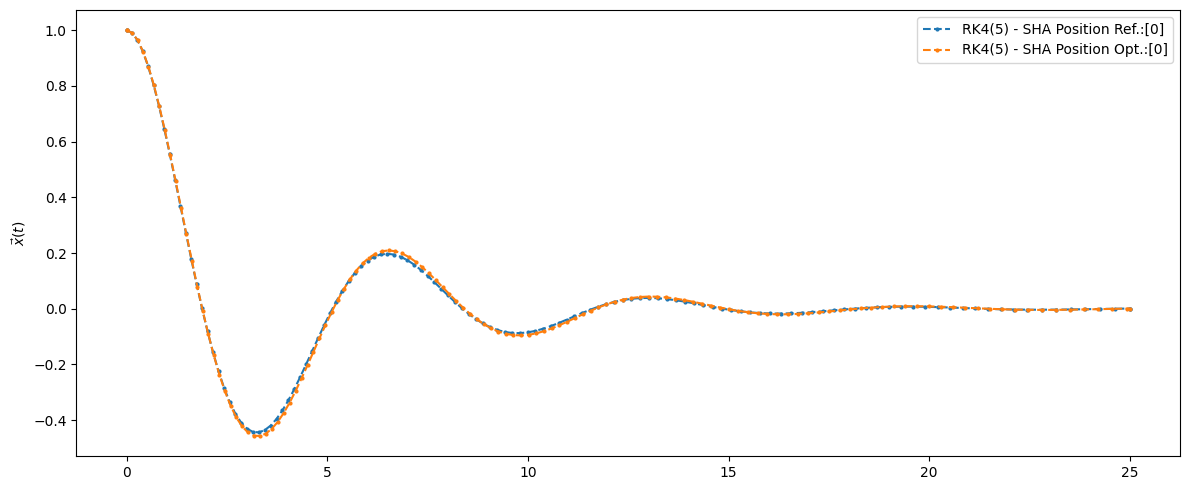

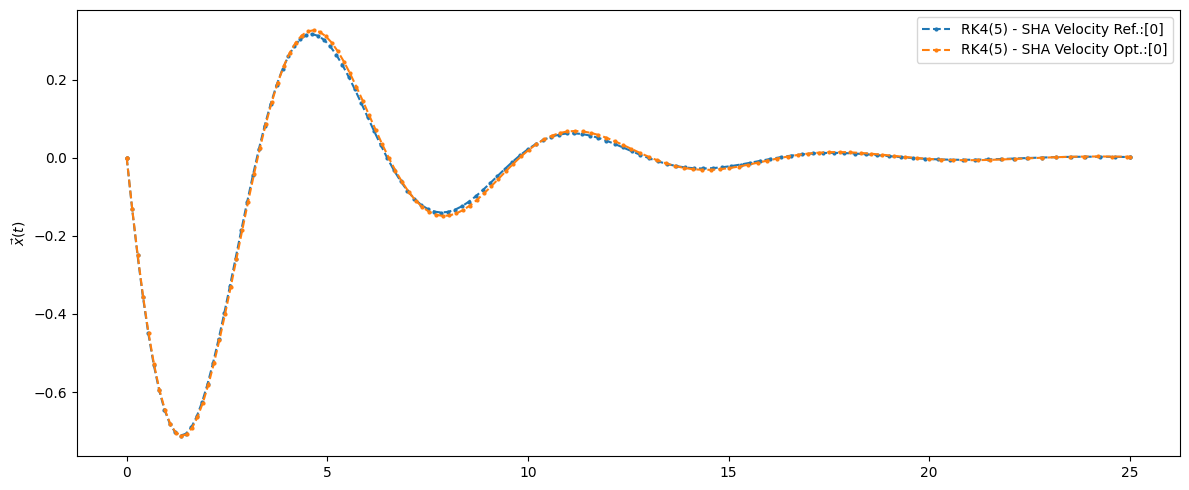

In [28]:
_, _, sha_states_ref, sha_times_ref, _ = adaptive_rk45_integrator.apply(sha_dynamics, initial_x, initial_time, final_time, dt, atol, rtol, frequency, damping)
fig_ref_position, axes_ref_position = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Position Ref.")
fig_ref_velocity, axes_ref_velocity = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_ref, sha_times_ref)], method_label="RK4(5) - SHA Velocity Ref.")

_, _, sha_states_optimised, sha_times_optimised, _ = adaptive_rk45_integrator.apply(sha_dynamics, initial_x, initial_time, final_time, dt, atol, rtol, best_frequency, best_damping)
_ = neuralode.plot.trajectory.plot_trajectory([(i[0], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_position, method_label="RK4(5) - SHA Position Opt.")
_ = neuralode.plot.trajectory.plot_trajectory([(i[1], j) for i, j in zip(sha_states_optimised, sha_times_optimised)], axes=axes_ref_velocity, method_label="RK4(5) - SHA Velocity Opt.")

Excellent, this takes the same number of optimisation steps, but we achieve better results. While at each step, the estimate is noisy as we don't account for all the points, we do gain in terms of convergence speed. Furthermore, we achieve a better error because we're less likely to be trapped in a local minimum.

Let's now suppose that we don't know what the dynamics are at all, can we learn the appropriate system? Probably, but right now our method of computing the gradients is exceptionally inefficient, and is the reason why we cannot run our integration at higher precision. To resolve this, we will need to employ the adjoint method.

## Appendix - Local Extrapolation

If you'll notice, in the above adaptive integration schemes, we have two estimates of the trajectory, a higher and a lower order one. While the error analysis of stepsize adaptation applies to the trajectory of the lower order estimate, in practice it can make sense to use the higher order estimate as it provides improved convergence for many systems. This is referred to as local extrapolation.

Below, we demonstrate how local extrapolation effects the error terms and their growth over a trajectory:

In [29]:
adaptive_rk45_integrator_without_local_extrapolation = get_integrator(torch.tensor([
    [0.0,       0.0,         0.0,        0.0,         0.0,      0.0,          0.0,      0.0 ],
    [1/5,       1/5,         0.0,        0.0,         0.0,      0.0,          0.0,      0.0 ],
    [3/10,      3/40,        9/40,       0.0,         0.0,      0.0,          0.0,      0.0 ],
    [4/5,       44/45,      -56/15,      32/9,        0.0,      0.0,          0.0,      0.0 ],
    [8/9,       19372/6561, -25360/2187, 64448/6561, -212/729,  0.0,          0.0,      0.0 ],
    [1.0,       9017/3168,  -355/33,     46732/5247,  49/176,  -5103/18656,   0.0,      0.0 ],
    [1.0,       35/384,      0.0,        500/1113,    125/192, -2187/6784,    11/84,    0.0 ],
    [torch.inf, 35/384,      0.0,        500/1113,    125/192, -2187/6784,    11/84,    0.0 ],
    [torch.inf, 5179/57600,  0.0,        7571/16695,  393/640, -92097/339200, 187/2100, 1/40]
], dtype=torch.float64), integrator_order = 5, use_local_extrapolation = False, integrator_name = "AdaptiveRK45IntegratorNoLocalExtrapolation")
adaptive_rk45_integrator_with_local_extrapolation = get_integrator(adaptive_rk45_integrator_without_local_extrapolation.integrator_tableau, integrator_order = 5, use_local_extrapolation = True, integrator_name = "AdaptiveRK45IntegratorLocalExtrapolation")

C:\Users\ekin4\AppData\Local\Temp\ipykernel_12600\3045801384.py:58: RuntimeWarning: Absolute tolerance is smaller than the square root of the epsilon for torch.float64, this may increase truncation error
  warnings.warn(f"Absolute tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error", RuntimeWarning)
C:\Users\ekin4\AppData\Local\Temp\ipykernel_12600\3045801384.py:76: RuntimeWarning: Relative tolerance is smaller than the square root of the epsilon for torch.float64, this may increase truncation error
  warnings.warn(f"Relative tolerance is smaller than the square root of the epsilon for {x0.dtype}, this may increase truncation error", RuntimeWarning)


Error in <class '__main__.AdaptiveRK45IntegratorLocalExtrapolation'>:    5.551115123125783e-17
Error in <class '__main__.AdaptiveRK45IntegratorNoLocalExtrapolation'>: 4.6129766673175254e-14


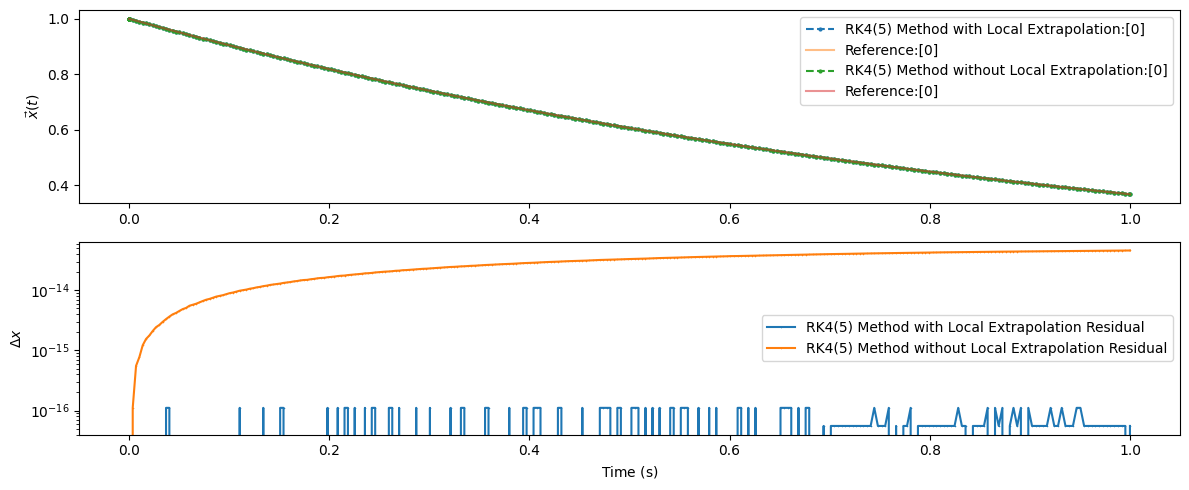

In [30]:
dt = (t1 - t0)/1e6

*_, sub_states_upper, sub_times_upper, state_errors_upper = adaptive_rk45_integrator_with_local_extrapolation.apply(neuralode.dynamics.exponential_fn, x0, t0, t1, dt, torch.tensor(5e-16), torch.tensor(5e-16))
*_, sub_states_lower, sub_times_lower, state_errors_lower = adaptive_rk45_integrator_without_local_extrapolation.apply(neuralode.dynamics.exponential_fn, x0, t0, t1, dt, torch.tensor(5e-16), torch.tensor(5e-16))

print(f"Error in {adaptive_rk45_integrator_with_local_extrapolation}:    {(sub_states_upper[-1] - neuralode.dynamics.exponential_fn_solution(x0, t1)).abs().item()}")
print(f"Error in {adaptive_rk45_integrator_without_local_extrapolation}: {(sub_states_lower[-1] - neuralode.dynamics.exponential_fn_solution(x0, t1)).abs().item()}")

reference_trajectory = [neuralode.dynamics.exponential_fn_solution(x0, t) for t in sub_times_upper]
fig, axes = neuralode.plot.trajectory.plot_trajectory_with_reference([(i[0], j) for i, j in zip(sub_states_upper, sub_times_upper)], reference_trajectory, method_label="RK4(5) Method with Local Extrapolation")
# axes[1].plot([t.item() for _, t in sub_states_upper], [e.abs().item() for e in state_errors_upper], marker='x', label="Estimated Error")
# axes[1].legend()

reference_trajectory = [neuralode.dynamics.exponential_fn_solution(x0, t) for t in sub_times_lower]
fig, axes = neuralode.plot.trajectory.plot_trajectory_with_reference([(i[0], j) for i, j in zip(sub_states_lower, sub_times_lower)], reference_trajectory, method_label="RK4(5) Method without Local Extrapolation", axes=axes)
# axes[1].plot([t.item() for _, t in sub_states_lower], [e.abs().item() for e in state_errors_lower], marker='x', label="Estimated Error")
# axes[1].legend()

As you can see, the use of local extrapolation leads to higher precision results over the whole trajectory for the same error tolerances. This usually implies that a) we can take fewer integration steps to achieve the same results and b) we can do so by relaxing the tolerances.